In [1]:
import import_ipynb

import sys

from Dynamic_resistancelib import *

import scipy as sc
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'figure.max_open_warning': 0})

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

import colorsys

import seaborn
seaborn.set(style='ticks')

print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)

importing Jupyter notebook from Dynamic_resistancelib.ipynb
importing Jupyter notebook from log_normal_truncated_ab.ipynb
Python version:  3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version:  1.17.2
matplotlib version:  3.1.1


In [2]:
#####################################   
## Calc Hazard Ratios from KP data ##
#####################################   
def calcHazardRatio(patResA,patResB):
    #patResA,patResB - time series events from two treatment arms
    
    #Mantel Haneszel Approach
    #http://doi.org/10.2307/2530564
    #https://www.graphpad.com/support/faq/hazard-ratio-from-survival-analysis/
    
    kmf.fit(patResA,patResA<60,alpha=1-0.95)
    timeA = kmf.timeline
    dataA = np.array(kmf.event_table)

    kmf.fit(patResB,patResB<60,alpha=1-0.95)
    timeB = kmf.timeline
    dataB = np.array(kmf.event_table)    

    time = np.intersect1d(timeA,timeB)
    expA = np.zeros(len(time)-1)
    obsA = np.zeros(len(time)-1)
    expB = np.zeros(len(time)-1)
    obsB = np.zeros(len(time)-1)
    var = np.zeros(len(time)-1)
    for i in range(len(time)-1): #dont need t=60            
        
        indA = np.array(np.where(timeA==time[i]))
        indB = np.array(np.where(timeB==time[i]))
          
        obsA[i] = dataA[indA,1]
        obsB[i] = dataB[indB,1]
        expA[i] = (obsA[i]+obsB[i])*(dataA[indA,4]/(dataA[indA,4]+dataB[indB,4]))
        expB[i] = (obsA[i]+obsB[i])*(dataB[indB,4]/(dataA[indA,4]+dataB[indB,4]))
        var[i] = ((obsA[i]+obsB[i])*((dataA[indA,4]+dataB[indB,4])-(obsA[i]+obsB[i]))*dataA[indA,4]*dataB[indB,4])/((dataA[indA,4]+dataB[indB,4])**2*(dataA[indA,4]+dataB[indB,4]-1))
    
    V = sum(var)
    LA = (sum(obsA)-sum(expA))/V
    LB = (sum(obsB)-sum(expB))/V
    HR = np.exp(LA)
    HR_95CI_L = np.exp(LA-1.96/V**0.5)
    HR_95CI_H = np.exp(LA+1.96/V**0.5)
    return HR,HR_95CI_L,HR_95CI_H,V

In [3]:
#loop over resistant/persistant vol frac & induction lengths
num_months = 60                         #5 yrs - length of simulations
n_sample=1024                           #number of simulated patients
initResFrac = [0.0001,0.001,0.01,0.1]   #initial resistant fractions
initPerFrac = [0.05, 0.2, 0.5]          #initial persistant fractions
wk_TKI_Induction = [0,1,2,4,8,12,16]    #various inductions lengths

######## Create Data Arrays to Load Model Run Data #####
PatRes_TKIOnly = np.zeros([n_sample,4,4,3])
PatRes_CRTOnly_WT = np.zeros([n_sample,3,4,3,2]) # last dim concurr and sequent
PatRes_TKICRT = np.zeros([n_sample,3,4,3,len(wk_TKI_Induction),2])# last dim->no main, main

LR_TKICRT_All = np.zeros([num_months+1,len(wk_TKI_Induction),2])# last dim->no main, main
DR_TKICRT_All = np.zeros([num_months+1,len(wk_TKI_Induction),2])# last dim->no main, main
PFS_TKICRT_All  = np.zeros([num_months+1,len(wk_TKI_Induction),2])# last dim->no main, main  
LR_Med_TKICRT_All = np.zeros([len(wk_TKI_Induction),2])# last dim->no main, main
DR_Med_TKICRT_All = np.zeros([len(wk_TKI_Induction),2])# last dim->no main, main
PFS_Med_TKICRT_All  = np.zeros([len(wk_TKI_Induction),2]) # last dim->no main, main

####################### Load Model Run Data #####################################
# this will produce paper figures
# change to 'ModelOutputs' to load data generated in _SecondModel
pth = 'PaperOutputs' #'PaperOutputs' will load data to create figures in paper
#################################################################################
for ipp in range(len(initPerFrac)):
    for ipr in range(len(initResFrac)):
        #TKI only until progression 
        PatRes_TKIOnly[:,:,ipr,ipp] = np.genfromtxt(pth+'/PatientRes_TKIonlyUntilProg_ResFract{0}_PerFract{1}_mu1e-07_StageIV.csv'.format(initResFrac[ipr],initPerFrac[ipp]),delimiter=',');
        #CRT only (0 weeks of induction and no maintenance)
        PatRes_CRTOnly_WT[:,:,ipr,ipp,0] =np.genfromtxt(pth+'/PatientRes_TKIpreCRT_ResFract{0}_PerFract{1}_mu1e-07_wkTKIset0_WT.csv'.format(initResFrac[ipr],initPerFrac[ipp]),delimiter=',');
        #Sequential CRT only
        PatRes_CRTOnly_WT[:,:,ipr,ipp,1] =np.genfromtxt(pth+'/PatientRes_TKIpreCRT_Sequential_ResFract{0}_PerFract{1}_mu1e-07_wkTKIset0_WT.csv'.format(initResFrac[ipr],initPerFrac[ipp]),delimiter=',');

        for ipt in range(len(wk_TKI_Induction)):
            #TKI Indcution without maintenance
            PatRes_TKICRT[:,:,ipr,ipp,ipt,0] = np.genfromtxt(pth+'/PatientRes_TKIpreCRT_ResFract{0}_PerFract{1}_mu1e-07_wkTKIset{2}.csv'.format(initResFrac[ipr],initPerFrac[ipp],wk_TKI_Induction[ipt]), delimiter=',');
            #TKI Indcution with maintenance until progression
            PatRes_TKICRT[:,:,ipr,ipp,ipt,1] = np.genfromtxt(pth+'/PatientRes_TKIpreAndpostCRTuntilProg_ResFract{0}_PerFract{1}_mu1e-07_wkTKIset{2}.csv'.format(initResFrac[ipr],initPerFrac[ipp],wk_TKI_Induction[ipt]), delimiter=',');

################## Calc % Remaining at Each Month & Meidan ###############
for ipt in range(len(wk_TKI_Induction)):
    for itreat in range(2):
        LR_TKICRT_All[:,ipt,itreat] = Calc_Cumulative_Curve(np.ndarray.flatten(PatRes_TKICRT[:,0,0:4,:,ipt,itreat]))
        DR_TKICRT_All[:,ipt,itreat] = Calc_Cumulative_Curve(np.ndarray.flatten(PatRes_TKICRT[:,1,0:4,:,ipt,itreat]))
        PFS_TKICRT_All[:,ipt,itreat] = Calc_Cumulative_Curve(np.ndarray.flatten(PatRes_TKICRT[:,2,0:4,:,ipt,itreat]))
        LR_Med_TKICRT_All[ipt,itreat] = np.median(np.ndarray.flatten(PatRes_TKICRT[:,0,0:4,:,ipt,itreat]))
        DR_Med_TKICRT_All[ipt,itreat] = np.median(np.ndarray.flatten(PatRes_TKICRT[:,1,0:4,:,ipt,itreat]))
        PFS_Med_TKICRT_All[ipt,itreat] = np.median(np.ndarray.flatten(PatRes_TKICRT[:,2,0:4,:,ipt,itreat]))


<Figure size 432x432 with 0 Axes>

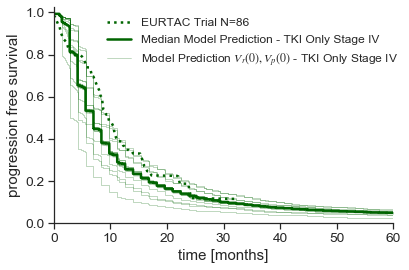

In [4]:
################################################################################################################
######## Load the Literature CRT only and TKI only Trial Data Used for Benchmarking ###########################
################################################################################################################ 
Lung_StageIIIAB_CRT_ETO = np.genfromtxt('LiteratureData/PROCLAIM_PFS_ETO-Cis.csv', delimiter=',')
Lung_StageIIIAB_CRT_PEM = np.genfromtxt('LiteratureData/PROCLAIM_PFS_Pem-Cis.csv', delimiter=',')
Lung_StageIIIAB_CRT_ETO[0,0]=0;Lung_StageIIIAB_CRT_ETO[0,1]=1
Lung_StageIIIAB_CRT_PEM[0,0]=0;Lung_StageIIIAB_CRT_PEM[0,1]=1
Lung_StageIIIAB_CRT_ETO_Interp=sc.interpolate.interp1d(Lung_StageIIIAB_CRT_ETO[:,0],Lung_StageIIIAB_CRT_ETO[:,1])
Lung_StageIIIAB_CRT_PEM_Interp=sc.interpolate.interp1d(Lung_StageIIIAB_CRT_PEM[:,0],Lung_StageIIIAB_CRT_PEM[:,1])
Lung_StageIIIAB_CRT_ETO_Mo=Lung_StageIIIAB_CRT_ETO_Interp(range(0,60+1,1));#interpolate over integer months
Lung_StageIIIAB_CRT_PEM_Mo=Lung_StageIIIAB_CRT_PEM_Interp(range(0,60+1,1));
Lung_StageIIIAB_CRT_PROCLAIM = (Lung_StageIIIAB_CRT_ETO_Mo+Lung_StageIIIAB_CRT_PEM_Mo)/2 #average both arms
PFS_PROCLAIM = Lung_StageIIIAB_CRT_PROCLAIM

PFS_EURTRAC = np.array(np.genfromtxt('LiteratureData/TKI_Only_StageIV_2_PFSCurve_Data.csv', delimiter=','))
PFS_EURTRAC_Interp = sc.interpolate.interp1d(PFS_EURTRAC[:,0],PFS_EURTRAC[:,1],kind="nearest",bounds_error=False,fill_value="extrapolate")(np.arange(0,int(np.max(PFS_EURTRAC[:,0]))+0.25,0.25))    

############################  
# PFS K-P - TKI Only
############################                    
PatRes_TKIOnly_All =  np.ndarray.flatten(PatRes_TKIOnly[:,2,:,:])                
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    ax0 =plt.plot(np.arange(0,int(np.max(PFS_EURTRAC[:,0]))+0.25,0.25),PFS_EURTRAC_Interp ,linestyle=':',linewidth = 2.5,color = 'darkgreen',label='EURTAC Trial N=86')   
    kmf.fit(PatRes_TKIOnly_All,event_observed= PatRes_TKIOnly_All<60,alpha=1-0.95,label='Median Model Prediction - TKI Only Stage IV')
    ax1 = kmf.plot(ax=ax,color = 'darkgreen',linewidth=2.5)        
    for ipp in [0,1,2]:
        for ip in [0,1,2,3]:
            tmp_sum = ipp*4 + ip
            c = '#{:02x}{:02x}{:02x}'.format(round(255*(tmp_sum/11)),round(255*((11-tmp_sum)/11)),0)
            if (ipp==0)&(ip==0):
                kmf.fit(PatRes_TKIOnly[:,2,ip,ipp],event_observed= PatRes_TKIOnly[:,2,ip,ipp]<60,alpha=1-0.95,label='Model Prediction $V_{r}(0),V_{p}(0)$ - TKI Only Stage IV')
                ax2 = kmf.plot(ax=ax,color = 'darkgreen',linestyle='-',linewidth=0.75,alpha=0.33,ci_show=False)
            else:
                kmf.fit(PatRes_TKIOnly[:,2,ip,ipp],event_observed= PatRes_TKIOnly[:,2,ip,ipp]<60,alpha=1-0.95, label='')
                ax3 = kmf.plot(ax=ax,color = 'darkgreen',linestyle='-',linewidth=0.75,alpha=0.33,ci_show=False,legend=False)
    ax.legend(bbox_to_anchor=(0.125, 1),prop={'size': 12},frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('progression free survival')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

<Figure size 432x432 with 0 Axes>

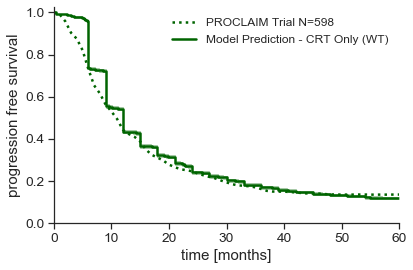

In [5]:
############################  
# PFS K-P - CRT Only
############################  
PatRes_CRTOnly_All =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,2,:,:,0])                
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    plt.plot(range(61),PFS_PROCLAIM ,linewidth = 2.5,linestyle=':',alpha = 1,color = 'darkgreen',label='PROCLAIM Trial N=598')   
    kmf.fit(PatRes_CRTOnly_All,event_observed= PatRes_CRTOnly_All<60,alpha=1-0.95,label= 'Model Prediction - CRT Only (WT)')
    ax = kmf.plot(ax=ax,color = 'darkgreen',linewidth=2.5)        
    ax.legend(prop={'size': 12},frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('progression free survival')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

<Figure size 432x432 with 0 Axes>

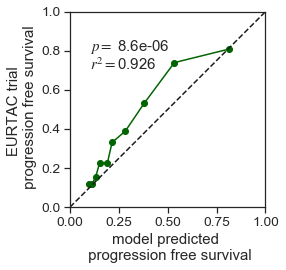

<Figure size 432x432 with 0 Axes>

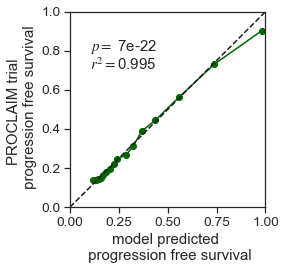

In [6]:
#################################################    
# Trial versus Model - TKI only and CRT Only
#################################################    

ModVsTrial_TKIOnly = np.zeros([10,2])
ModVsTrial_CRTonly = np.zeros([20,2])
kmf.fit(PatRes_TKIOnly_All,event_observed= PatRes_TKIOnly_All<60,alpha=1-0.95)
for imo in range(10):
    ind = np.where(kmf.timeline>=(imo+1)*3)[0][0]
    ModVsTrial_TKIOnly[imo,0]=np.array(kmf.survival_function_)[ind]
    ModVsTrial_TKIOnly[imo,1]=PFS_EURTRAC_Interp[int(4*(imo+1)*3)]
kmf.fit(PatRes_CRTOnly_All,event_observed= PatRes_CRTOnly_All<60,alpha=1-0.95)
for imo in range(20):
    ind = np.where(kmf.timeline>=(imo+1)*3)[0][0]
    ModVsTrial_CRTonly[imo,0]=np.array(kmf.survival_function_)[ind]
    ModVsTrial_CRTonly[imo,1]=PFS_PROCLAIM[int((imo+1)*3)]

slope, intercept, r_value, p_value, std_err = sc.stats.linregress(ModVsTrial_TKIOnly[:,0], ModVsTrial_TKIOnly[:,1])
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    plt.plot(ModVsTrial_TKIOnly[:,0],ModVsTrial_TKIOnly[:,1],'o-',color = 'darkgreen')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('model predicted \n progression free survival')
    plt.ylabel('EURTAC trial \n progression free survival')
    plt.text(0.1,0.7,'$r^2 =$' + str(round(r_value**2,3)))
    plt.text(0.1,0.8,'$p =$ {0}'.format(round(p_value,7)))
    plt.axis([0,1,0,1])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()  

slope, intercept, r_value, p_value, std_err = sc.stats.linregress(ModVsTrial_CRTonly[:,0], ModVsTrial_CRTonly[:,1])
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    plt.plot(ModVsTrial_CRTonly[:,0],ModVsTrial_CRTonly[:,1],'o-',color = 'darkgreen')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('model predicted \n progression free survival')
    plt.ylabel('PROCLAIM trial \n progression free survival')
    plt.text(0.1,0.7,'$r^2 =$' + str(round(r_value**2,3)))
    plt.text(0.1,0.8,'$p =$ {0}'.format(round(p_value,22)))
    plt.axis([0,1,0,1])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()  

<Figure size 288x432 with 0 Axes>

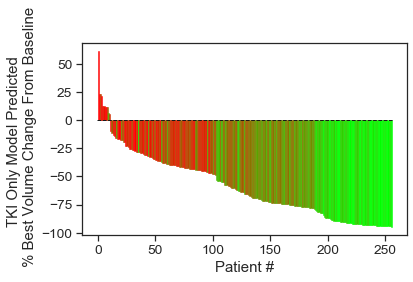

In [7]:
############################################################
#TKI only - Waterfall plot of 256 randomly selected pts
#           stratified by initial resistance & persistance
############################################################

i_per = np.random.randint(0,len(initPerFrac),256)
i_res = np.random.randint(0,len(initResFrac),256)
Vdelta_noCRT_All_Tot = np.zeros(256)
Vdelta_colors_Sum = np.ones([256,4])
for i in range(256):
    tempPatRes = PatRes_TKIOnly[:,3,i_res[i],i_per[i]]
    np.random.shuffle(tempPatRes)
    Vdelta_noCRT_All_Tot[i] = tempPatRes[0]
    tmp_sum = i_per[i]*4 + i_res[i]
    Vdelta_colors_Sum[i,0:3] = [tmp_sum/11,(11-tmp_sum)/11,0]
ind = np.argsort(-Vdelta_noCRT_All_Tot)
Vdelta_noCRT_All = 100*Vdelta_noCRT_All_Tot[ind]
Vdelta_colors_Sum = Vdelta_colors_Sum[ind,:]

plt.figure(figsize=[4,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    plt.bar(np.arange(0.5,len(Vdelta_noCRT_All)+0.5,1),Vdelta_noCRT_All,width=1,color=Vdelta_colors_Sum,linewidth=0.5,edgecolor=Vdelta_colors_Sum)
    plt.plot([-1,len(Vdelta_noCRT_All)],[0,0],'k--',linewidth=1)
    plt.xlabel('Patient #')
    plt.ylabel('TKI Only Model Predicted \n % Best Volume Change From Baseline')
    fig.tight_layout()


<Figure size 432x432 with 0 Axes>

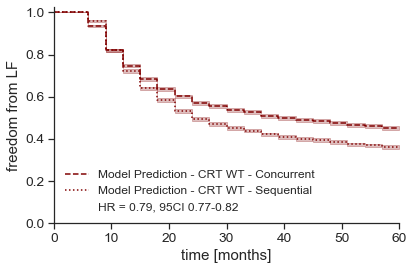

<Figure size 432x432 with 0 Axes>

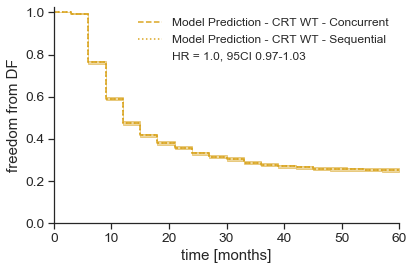

In [8]:
##########################################
# FFLF,FFDF K-P - CRT Only WT Con vs Seq
##########################################

PatResLR_CRTOnly_All_Con =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,0,:,:,0]) 
PatResLR_CRTOnly_All_Seq =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,0,:,:,1]) 
HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(PatResLR_CRTOnly_All_Con,PatResLR_CRTOnly_All_Seq)               
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    kmf.fit(PatResLR_CRTOnly_All_Con,event_observed= PatResLR_CRTOnly_All_Con<60,alpha=1-0.95,label= 'Model Prediction - CRT WT - Concurrent')
    ax = kmf.plot(ax=ax,color = 'maroon',linewidth=1.5,linestyle = '--') 
    kmf.fit(PatResLR_CRTOnly_All_Seq,event_observed= PatResLR_CRTOnly_All_Seq<60,alpha=1-0.95,label= 'Model Prediction - CRT WT - Sequential')
    ax = kmf.plot(ax=ax,color = 'maroon',linewidth=1.5,linestyle = ':')        
    plt.plot([],[],alpha=0,label = 'HR = {0}, 95CI {1}-{2}'.format(round(HR,2),round(HR_95CI_L,2),round(HR_95CI_H,2)))    
    ax.legend(prop={'size': 12},frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('freedom from LF')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

##############  
PatResDR_CRTOnly_All_Con =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,1,:,:,0]) 
PatResDR_CRTOnly_All_Seq =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,1,:,:,1]) 
HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(PatResDR_CRTOnly_All_Con,PatResDR_CRTOnly_All_Seq)               
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    kmf.fit(PatResDR_CRTOnly_All_Con,event_observed= PatResDR_CRTOnly_All_Con<60,alpha=1-0.95,label= 'Model Prediction - CRT WT - Concurrent')
    ax = kmf.plot(ax=ax,color = 'goldenrod',linewidth=1.5,linestyle = '--') 
    kmf.fit(PatResDR_CRTOnly_All_Seq,event_observed= PatResDR_CRTOnly_All_Seq<60,alpha=1-0.95,label= 'Model Prediction - CRT WT - Sequential')
    ax = kmf.plot(ax=ax,color = 'goldenrod',linewidth=1.5,linestyle = ':')        
    plt.plot([],[],alpha=0,label = 'HR = {0}, 95CI {1}-{2}'.format(round(HR,2),round(HR_95CI_L,2),round(HR_95CI_H,2)))    
    ax.legend(prop={'size': 12},frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('freedom from DF')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

<Figure size 432x432 with 0 Axes>

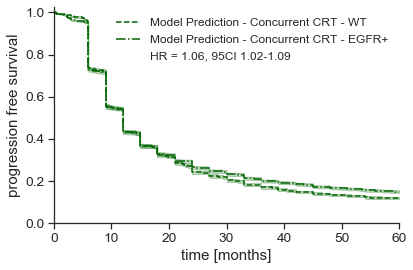

In [9]:
##########################################
#PFS K-P - Con CRT Only WT vs EGFR+
##########################################

PatResPFS_CRTOnly_All_WT =  np.ndarray.flatten(PatRes_CRTOnly_WT[:,2,:,:,0]) 
PatResPFS_CRTOnly_All_EGFR =  np.ndarray.flatten(PatRes_TKICRT[:,2,:,:,0,0]) 
HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(PatResPFS_CRTOnly_All_WT,PatResPFS_CRTOnly_All_EGFR)               
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    fig,ax = plt.subplots()
    kmf.fit(PatResPFS_CRTOnly_All_WT,event_observed= PatResPFS_CRTOnly_All_WT<60,alpha=1-0.95,label= 'Model Prediction - Concurrent CRT - WT')
    ax = kmf.plot(ax=ax,color = 'darkgreen',linewidth=1.5,linestyle = '--') 
    kmf.fit(PatResPFS_CRTOnly_All_EGFR,event_observed= PatResPFS_CRTOnly_All_EGFR<60,alpha=1-0.95,label= 'Model Prediction - Concurrent CRT - EGFR+')
    ax = kmf.plot(ax=ax,color = 'darkgreen',linewidth=1.5,linestyle = '-.')        
    plt.plot([],[],alpha=0,label = 'HR = {0}, 95CI {1}-{2}'.format(round(HR,2),round(HR_95CI_L,2),round(HR_95CI_H,2)))    
    ax.legend(prop={'size': 12},frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('progression free survival')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

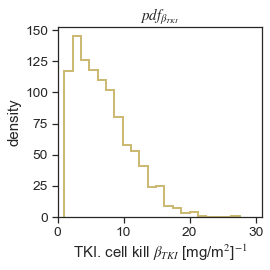

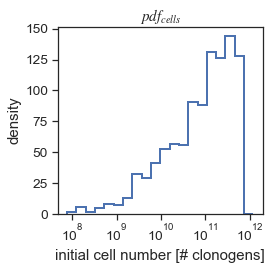

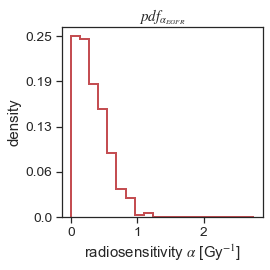

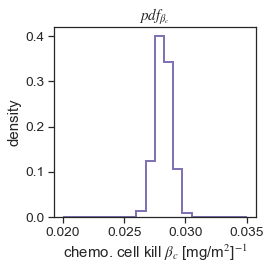

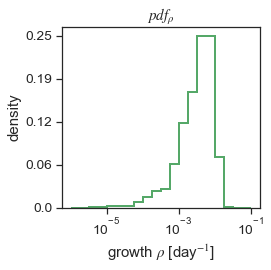

In [10]:
##################################
# historams of model parameters
##################################

#### Load model parameter distributions used in simulations ####
GMC = np.array(np.genfromtxt(pth+'/MC_Params_Strata.csv', delimiter=','))
Stest_InitialDiameters = GMC[:,0] 
GVinblastine_u = GMC[:,1]
Gcisplatin_u = GMC[:,2]
Galpha = GMC[:,3]
Gr_sen = GMC[:,4]    
Gr_per = Gr_sen/4
Gr_res = Gr_sen;
Gbeta = GMC[:,5]    

#### Plot each histogram ####
plt.figure(figsize=[4,4])
h=plt.hist(Gbeta,bins=21,color='C8',linewidth=2,alpha=1,label='Simulated Population',density=False,histtype='step')
plt.yticks([0,25,50,75,100,125,150])
plt.ylabel('density')
plt.xlabel(r'TKI. cell kill $\beta_{TKI}$ [mg/m$^2$]$^{-1}$')
plt.title(r'$pdf_{\beta_{TKI}}$')
plt.xlim([0,31])
plt.tight_layout()   

plt.figure(figsize=[4,4])
h=plt.hist(5.8e8*4/3*np.pi*(Stest_InitialDiameters/2)**3,bins = 5.8e8*4/3*np.pi*(np.logspace(-0.2,1.2,21)/2)**3,density=False,color='C0',linewidth=2,alpha=1,histtype='step')
plt.xscale('log')
plt.xticks([10**8,10**9,10**10,10**11,10**12])
plt.yticks([0,25,50,75,100,125,150])
plt.tick_params(which="both", bottom=True)
plt.xlabel('initial cell number [# clonogens]')
plt.ylabel('density')
plt.title(r'$pdf_{cells}$')
plt.tight_layout()

plt.figure(figsize=[4,4]) 
h=plt.hist(Galpha,bins = np.linspace(0,2.75,21),density=False,color='C3',linewidth=2,alpha=1,histtype='step')
plt.xscale('linear')
plt.xlabel(r'radiosensitivity $\alpha$ [Gy$^{-1}$]')
plt.ylabel('density')
plt.yticks(np.array([0,0.25,0.5,0.75,1])*np.max(h[0]),np.round(np.array([0,0.25,0.5,0.75,1])*np.max(h[0])/n_sample,2))
plt.title(r'$pdf_{\alpha_{EGFR}}$')
plt.tight_layout()

plt.figure(figsize=[4,4]) 
h=plt.hist(GVinblastine_u,bins = np.linspace(0.02,0.035,21),density=False,color='C4',linewidth=2,alpha=1,histtype='step')
plt.xscale('linear')
plt.xlabel(r'chemo. cell kill $\beta_{c}$ [mg/m$^2$]$^{-1}$')
plt.ylabel('density')
plt.yticks(np.array([0,0.25,0.5,0.75,1])*np.max(h[0]),np.round(np.array([0,0.25,0.5,0.75,1])*np.max(h[0])/n_sample,2))
plt.title(r'$pdf_{\beta_{c}}$')
plt.tight_layout()

plt.figure(figsize=[4,4]) 
h=plt.hist(Gr_sen,bins = np.logspace(-6,-1,21),density=False,color='C2',linewidth=2,alpha=1,histtype='step')
plt.xscale('log')
plt.xlabel(r'growth $\rho$ [day$^{-1}$]')
plt.ylabel('density')
plt.yticks(np.array([0,0.25,0.5,0.75,1])*np.max(h[0]),np.round(np.array([0,0.25,0.5,0.75,1])*np.max(h[0])/n_sample,2))
plt.title(r'$pdf_{\rho}$')
plt.tight_layout()


array([[1.25, 1.2 , 1.31],
       [1.21, 1.15, 1.26],
       [1.19, 1.14, 1.25]])

array([[1.89, 1.83, 1.96],
       [1.48, 1.43, 1.52],
       [1.38, 1.34, 1.43]])

array([[1.74, 1.69, 1.8 ],
       [1.44, 1.39, 1.48],
       [1.38, 1.34, 1.42]])

<Figure size 432x432 with 0 Axes>

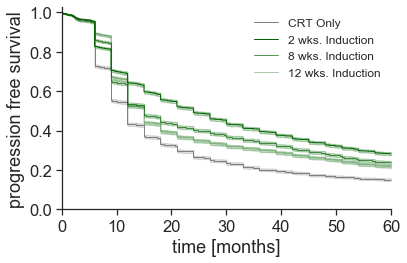

<Figure size 432x432 with 0 Axes>

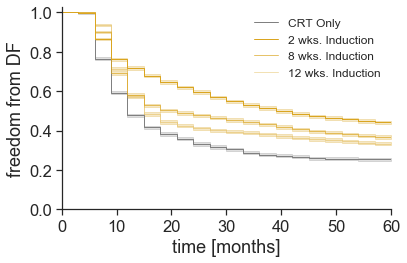

<Figure size 432x432 with 0 Axes>

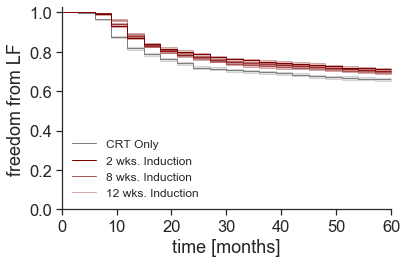

In [11]:
#####################################################################################
##### TKI + CRT KP plots for various Induction Times vs CRT only  ########
#####################################################################################
    
# Hazard Ratios 
HRs_noMain = np.zeros([3,3,3]) #1st dim, FFLF,FFDF,PFS, 2nd dim 3 different induction times, 3rd dim HR & CI
HRs_Main = np.zeros([3,3,3]) #1st dim, FFLF,FFDF,PFS, 2nd dim 3 different induction times, 3rd dim HR & CI
  
wk_plot= [0,1,2,4,8,12,16]
##### TKI + CRT PFS KP Curves #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.5)
    fig,ax = plt.subplots()
    cnt=0
    for iwk in [0,2,4,5]:          
        if iwk == 0:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,2,:,:,0,0])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='CRT Only')
            ax = kmf.plot(ax=ax,color = 'gray',linewidth=1,alpha=1,ci_show=True)      
        else:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,2,:,:,iwk,1])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='{0} wks. Induction'.format(wk_plot[iwk]))
            ax = kmf.plot(ax=ax,color = 'darkgreen',linewidth=1,alpha=(3-(cnt-1))/3,ci_show=True)      
            HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(np.ndarray.flatten(PatRes_TKICRT[:,2,:,:,0,0]),PatRes) 
            HRs_Main[2,cnt-1,:] = [HR,HR_95CI_L,HR_95CI_H]
        cnt += 1
    ax.legend(prop={'size': 12},ncol=1,frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('progression free survival')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

##### TKI + CRT FFDF KP Curves #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.5)
    fig,ax = plt.subplots()
    cnt=0
    for iwk in [0,2,4,5]:     
        if iwk == 0:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,1,:,:,0,0])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='CRT Only')
            ax = kmf.plot(ax=ax,color = 'gray',linewidth=1,alpha=1,ci_show=True)        
        else:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,1,:,:,iwk,1])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='{0} wks. Induction'.format(wk_plot[iwk]))
            ax = kmf.plot(ax=ax,color = 'goldenrod',linewidth=1,alpha=(3-(cnt-1))/3,ci_show=True) 
            HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(np.ndarray.flatten(PatRes_TKICRT[:,1,:,:,0,0]),PatRes) 
            HRs_Main[1,cnt-1,:] = [HR,HR_95CI_L,HR_95CI_H]
        cnt += 1
    ax.legend(prop={'size': 12},ncol=1,frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('freedom from DF')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  

##### TKI + CRT FFLF KP Curves #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.5)
    fig,ax = plt.subplots()
    cnt=0
    for iwk in [0,2,4,5]:
        if iwk == 0:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,0,:,:,0,0])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='CRT Only')
            ax = kmf.plot(ax=ax,color = 'gray',linewidth=1,alpha=1,ci_show=True)
        else:
            PatRes = np.ndarray.flatten(PatRes_TKICRT[:,0,:,:,iwk,1])
            kmf.fit(PatRes,event_observed= PatRes<60,alpha=1-0.95,label='{0} wks. Induction'.format(wk_plot[iwk]))
            ax = kmf.plot(ax=ax,color = 'maroon',linewidth=1,alpha=(3-(cnt-1))/3,ci_show=True)   
            HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(np.ndarray.flatten(PatRes_TKICRT[:,0,:,:,0,0]),PatRes) 
            HRs_Main[0,cnt-1,:] = [HR,HR_95CI_L,HR_95CI_H]
        cnt += 1
    ax.legend(prop={'size': 12},ncol=1,frameon=False)
    plt.xlim([0,60])
    plt.ylim([0,1.025])
    plt.xlabel('time [months]')
    plt.ylabel('freedom from LF')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  
    
   
    display(np.round( HRs_Main[0,:,:],2))
    display(np.round( HRs_Main[1,:,:],2))
    display(np.round( HRs_Main[2,:,:],2))

<Figure size 432x432 with 0 Axes>

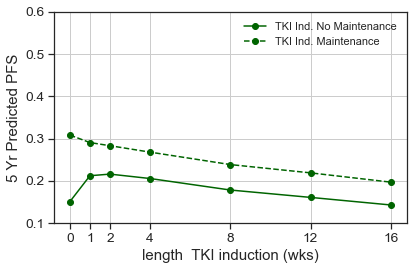

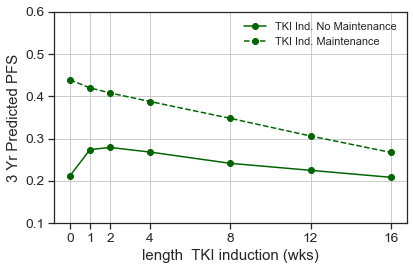

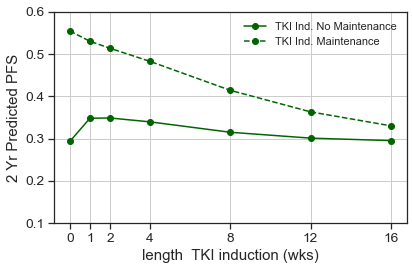

<Figure size 432x432 with 0 Axes>

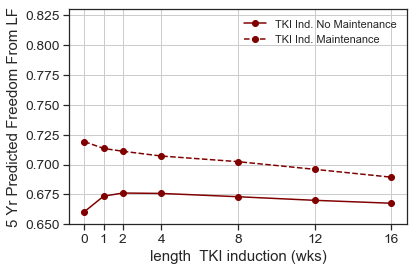

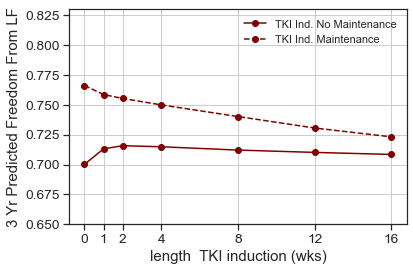

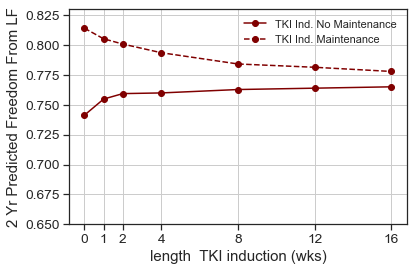

<Figure size 432x432 with 0 Axes>

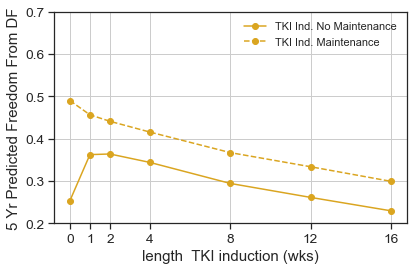

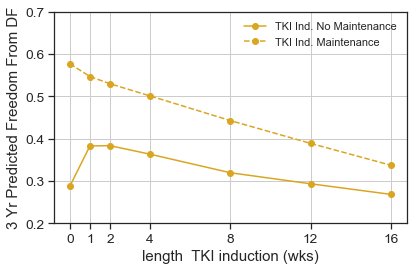

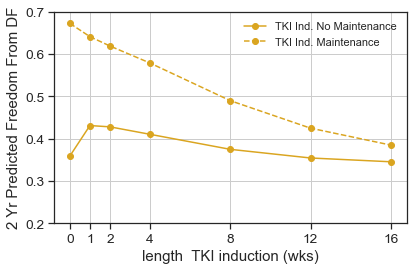

In [12]:
#####################################################################################
##### TKI + CRT Outcomes Vs. Induction Length (with and w/o Maintanence)  ########
#####################################################################################

wk_TKI_Induction_plot = [0,1,2,4,8,12,16]
##### PFS vs Induction Length #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    for timepoint in [5,3,2]:
        fig,ax = plt.subplots()
        plt.plot(wk_TKI_Induction_plot,PFS_TKICRT_All[timepoint*12,0:7,0],'o-',color = 'darkgreen',alpha =1,label = 'TKI Ind. No Maintenance')
        plt.plot(wk_TKI_Induction_plot,PFS_TKICRT_All[timepoint*12,0:7,1],'o--',color = 'darkgreen',alpha =1,label = 'TKI Ind. Maintenance')
        plt.xticks(wk_TKI_Induction_plot,wk_TKI_Induction_plot,rotation=0)
        plt.xlabel('length  TKI induction (wks)')
        plt.ylabel('{0} Yr Predicted PFS'.format(timepoint))
        plt.ylim([0.1,0.6])
        plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6])
        ax.legend(prop={'size': 11},frameon=False)
        plt.tight_layout()
        plt.grid()

##### FFLF vs Induction Length #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    for timepoint in [5,3,2]:
        fig,ax = plt.subplots()
        plt.plot(wk_TKI_Induction_plot,LR_TKICRT_All[timepoint*12,0:7,0],'o-',color = 'maroon',alpha =1,label = 'TKI Ind. No Maintenance')
        plt.plot(wk_TKI_Induction_plot,LR_TKICRT_All[timepoint*12,0:7,1],'o--',color = 'maroon',alpha =1,label = 'TKI Ind. Maintenance')
        plt.xticks(wk_TKI_Induction_plot,wk_TKI_Induction_plot,rotation=0)
        plt.xlabel('length  TKI induction (wks)')
        plt.ylabel('{0} Yr Predicted Freedom From LF'.format(timepoint))
        plt.ylim([0.65,0.83])
        plt.yticks([0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825])
        ax.legend(prop={'size': 11},frameon=False)
        plt.tight_layout()
        plt.grid()

##### FFDF vs Induction Length #####
plt.figure(figsize=[6,6])
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.25)
    for timepoint in [5,3,2]:
        fig,ax = plt.subplots()
        plt.plot(wk_TKI_Induction_plot,DR_TKICRT_All[timepoint*12,0:7,0],'o-',color = 'goldenrod',alpha =1,label = 'TKI Ind. No Maintenance')
        plt.plot(wk_TKI_Induction_plot,DR_TKICRT_All[timepoint*12,0:7,1],'o--',color = 'goldenrod',alpha =1,label = 'TKI Ind. Maintenance')
        plt.xticks(wk_TKI_Induction_plot,wk_TKI_Induction_plot,rotation=0)
        plt.xlabel('length  TKI induction (wks)')
        plt.ylabel('{0} Yr Predicted Freedom From DF'.format(timepoint))
        plt.ylim([0.2,0.7])
        plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7])
        ax.legend(prop={'size': 11},frameon=False)
        plt.tight_layout()
        plt.grid()

<Figure size 432x288 with 0 Axes>

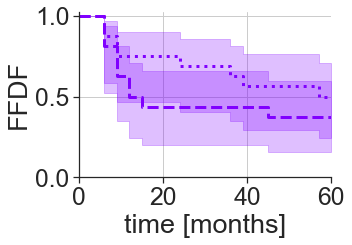

<Figure size 432x288 with 0 Axes>

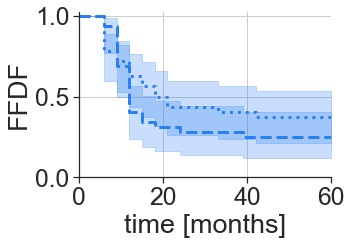

<Figure size 432x288 with 0 Axes>

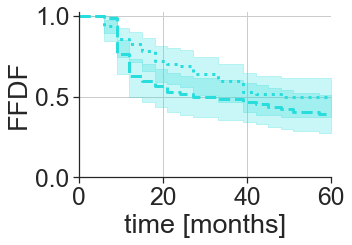

<Figure size 432x288 with 0 Axes>

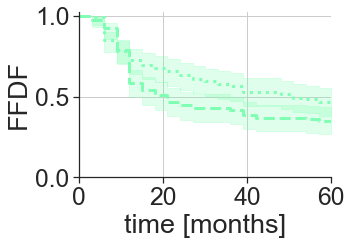

<Figure size 432x288 with 0 Axes>

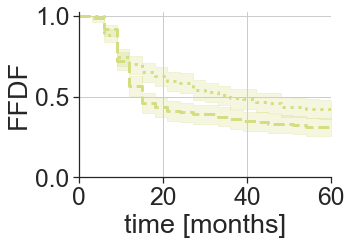

<Figure size 432x288 with 0 Axes>

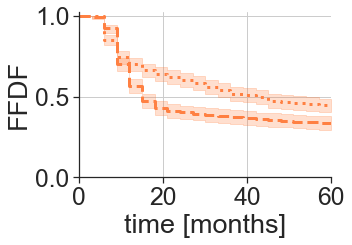

<Figure size 432x288 with 0 Axes>

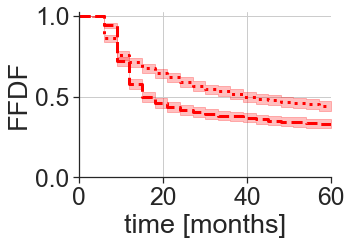

<Figure size 432x288 with 0 Axes>

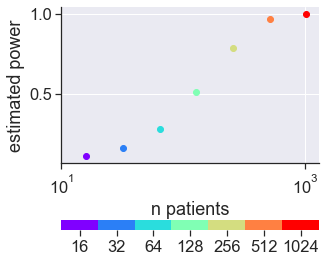

<Figure size 432x288 with 0 Axes>

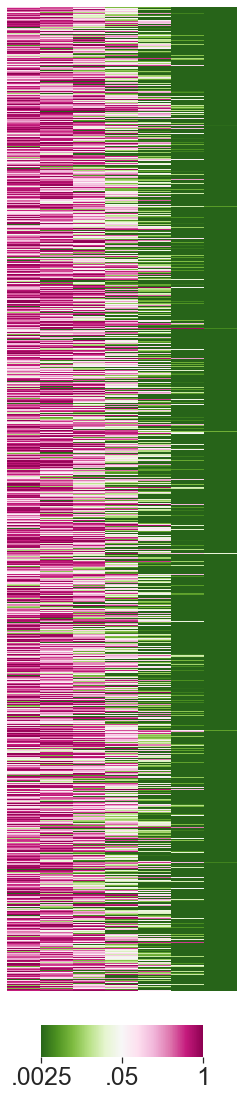

<Figure size 432x288 with 0 Axes>

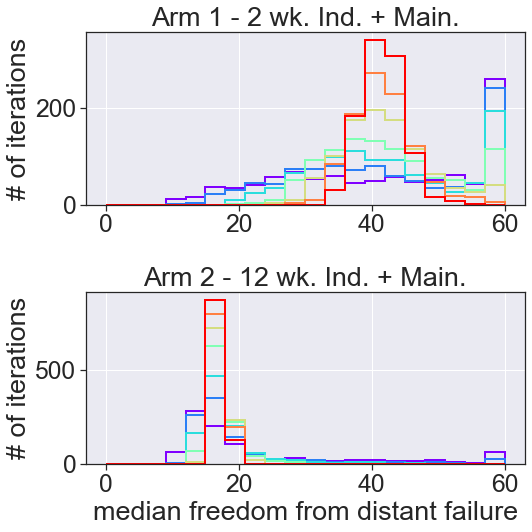

<Figure size 432x288 with 0 Axes>

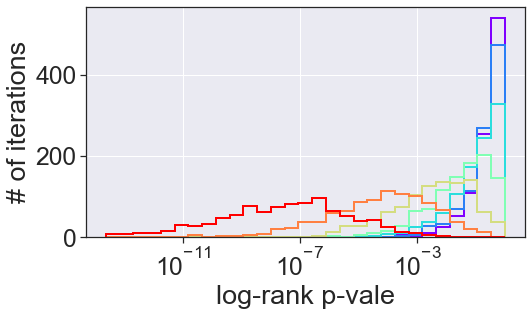

<Figure size 432x288 with 0 Axes>

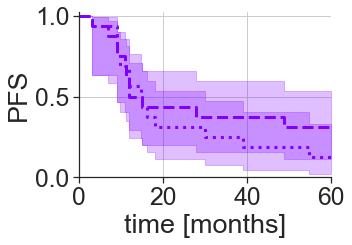

<Figure size 432x288 with 0 Axes>

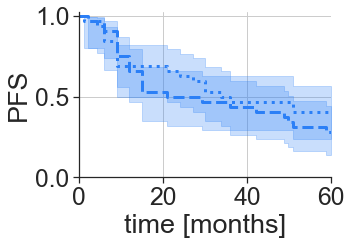

<Figure size 432x288 with 0 Axes>

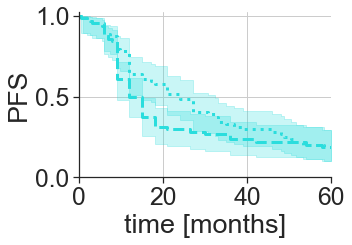

<Figure size 432x288 with 0 Axes>

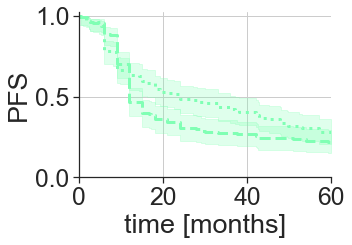

<Figure size 432x288 with 0 Axes>

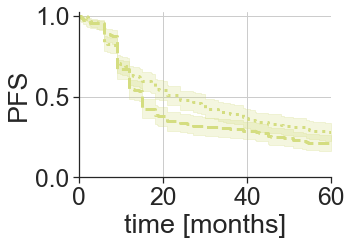

<Figure size 432x288 with 0 Axes>

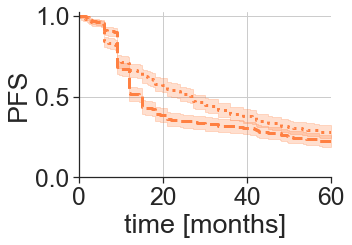

<Figure size 432x288 with 0 Axes>

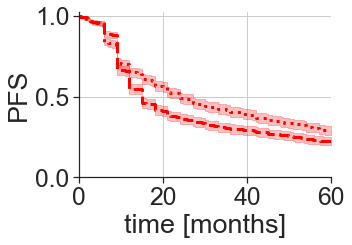

<Figure size 432x288 with 0 Axes>

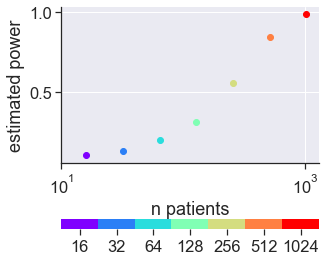

<Figure size 432x288 with 0 Axes>

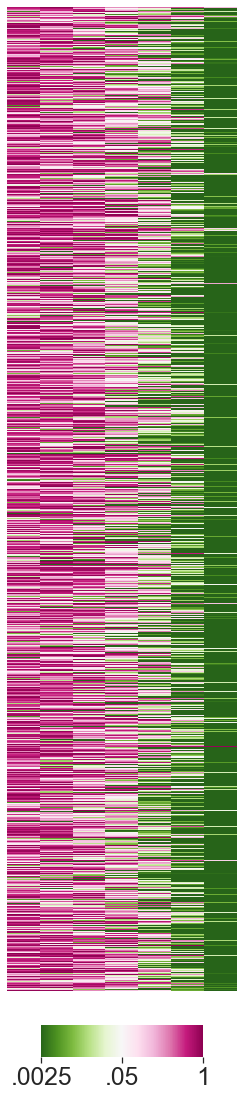

<Figure size 432x288 with 0 Axes>

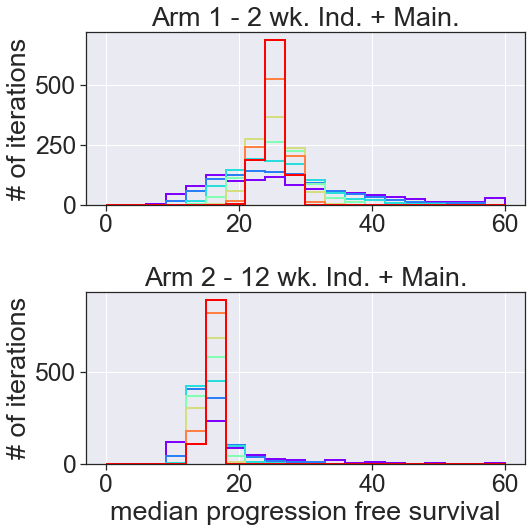

<Figure size 432x288 with 0 Axes>

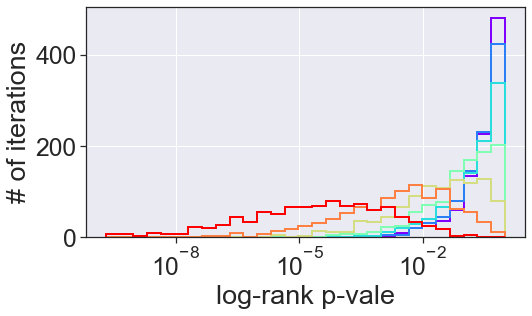

In [13]:
#####################################################################################
##### Trial Simulation -- statistics as a function of sample size  ##################
#####################################################################################
     
#iterate for FFDF and PFS
for saveMetric in ['FFDF','PFS']:
    if saveMetric == 'FFDF':
        PatRes_ind = 1
    elif saveMetric == 'PFS':
        PatRes_ind = 2

    PatRes_TKICRT_2wkMain =  np.ndarray.flatten(PatRes_TKICRT[:,PatRes_ind,:,:,2,1])   
    PatRes_TKICRT_12wkMain =  np.ndarray.flatten(PatRes_TKICRT[:,PatRes_ind,:,:,5,1])  

    cmap = plt.cm.get_cmap('rainbow', 7)
    n = [16,32,64,128,256,512,1024] #number to vary per arm (NOTE: If these numbers are greater than n_sample*12, will result in error)
    iterPower = 1000 #number of iterations
    pcut = 0.05

    pval_all = np.zeros([len(n),iterPower])
    med_pval = np.zeros(len(n))
    medEffect_Arm1 = np.zeros([len(n),iterPower])
    medEffect_Arm2 = np.zeros([len(n),iterPower])
    medArm1 = np.zeros([len(n),np.max(n)])
    medArm2 = np.zeros([len(n),np.max(n)])
    power_all = np.zeros(len(n))
    for iiter in range(iterPower):
        np.random.shuffle(PatRes_TKICRT_2wkMain)
        np.random.shuffle(PatRes_TKICRT_12wkMain)
        for inum in range(len(n)):
            tmpArm1 = PatRes_TKICRT_2wkMain[0:n[inum]]
            tmpArm2 = PatRes_TKICRT_12wkMain[0:n[inum]]
            results = logrank_test(tmpArm1, tmpArm2, tmpArm1<60, tmpArm2<60,t_0=-1)
            ipval = results.p_value
            pval_all[inum,iiter] = ipval
            medEffect_Arm1[inum,iiter] = np.median(tmpArm1)
            medEffect_Arm2[inum,iiter] = np.median(tmpArm2)
            if np.abs(ipval-np.median(pval_all[inum,0:iiter+1]))< np.abs(med_pval[inum]-np.median(pval_all[inum,0:iiter+1])):
                med_pval[inum] = ipval
                medArm1[inum,0:n[inum]] = tmpArm1
                medArm2[inum,0:n[inum]] = tmpArm2            
    
    ##### Plot Median K-P curves at each sample size #####
    for inum in range(len(n)):
        power_all[inum] = np.sum(pval_all[inum,:]<pcut)/iterPower
        plt.figure()
        with seaborn.axes_style("ticks"):
            seaborn.set(style='ticks',font_scale=2.25)
            fig,ax = plt.subplots(figsize=[5.5,4])        
            kmf.fit(medArm1[inum,0:n[inum]],event_observed= medArm1[inum,0:n[inum]]<60,alpha=1-0.95)
            ax = kmf.plot(ax=ax,color = cmap(inum/(len(n)-1)),linewidth=3,linestyle = ':',legend=False)
            kmf.fit(medArm2[inum,0:n[inum]],event_observed= medArm2[inum,0:n[inum]]<60,alpha=1-0.95)
            ax = kmf.plot(ax=ax,color = cmap(inum/(len(n)-1)),linewidth=3,linestyle = '--',legend=False)
            plt.xlim([0,60])
            plt.ylim([0,1.025])
            plt.xlabel('time [months]')
            plt.ylabel(saveMetric)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout()  
            plt.grid()

    ##### Plot Power versus sample size #####
    plt.figure()
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        seaborn.set_style("ticks", {"axes.grid": True,"axes.facecolor": "#EAEAF2","figure.facecolor": "white", "grid.color": "white"})
        fig,ax = plt.subplots(figsize=[5,4])        
        for inum in range(len(n)): 
            plt.loglog(n[inum],power_all[inum],'o',color = cmap(inum/(len(n)-1)))
        plt.xlabel('n patients')
        plt.yscale('linear');
        plt.xscale('log')
        plt.ylabel('estimated power')
        plt.xlim([10,1300])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar=plt.colorbar(sm,orientation='horizontal',fraction=0.06,pad=0.25,aspect=25,ticks=[1/14,3/14,5/14,7/14,9/14,11/14,13/14])
        cbar.outline.set_visible(False)
        cbar.set_ticklabels(['16', '32', '64','128','256','512','1024'])
        ax = plt.gca()
        ax.yaxis.tick_left()
        ax.spines['right'].set_visible(False) 
        ax.spines['top'].set_visible(False)
        plt.tight_layout() 
    
    ##### Heatmap of log-rank pvales for 1000 iterations #####
    plt.figure()
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=2.25)
        fig,ax = plt.subplots(figsize=[4,20])        
        plt.imshow(np.transpose(np.log10(pval_all)),cmap='PiYG_r',aspect=0.03);
        plt.axis('off')
        cbar=plt.colorbar(orientation='horizontal',fraction=0.024,pad=0.025,aspect=5,shrink=1,ticklocation='left',ticks=[2*np.log10(pcut),np.log10(pcut),0]);
        plt.clim([2*np.log10(pcut),0]);
        cbar.outline.set_visible(False)
        cbar.set_ticklabels(['.0025',  '.05','1'])
        plt.tight_layout()  

    ##### Histograms of 2 wk and 12 wk induction median endpoint #####
    plt.figure()
    with seaborn.axes_style("ticks"):
        seaborn.set_style("ticks", {"axes.grid": True,"axes.facecolor": "#EAEAF2","figure.facecolor": "white", "grid.color": "white"})
        fig,ax = plt.subplots(figsize=[8,8])  
        plt.subplot(2,1,1)
        for inum in range(len(n)):
            plt.hist(medEffect_Arm1[inum,:],np.arange(0,61,3), density=False,histtype='step',linestyle='-',linewidth=2,color = cmap(inum/(len(n)-1)),alpha=1)
        plt.title('Arm 1 - 2 wk. Ind. + Main.')
        plt.ylabel('# of iterations') 
        plt.subplot(2,1,2)
        for inum in range(len(n)):
            plt.hist(medEffect_Arm2[inum,:],np.arange(0,61,3), density=False,histtype='step',linestyle='-',linewidth=2,color = cmap(inum/(len(n)-1)),alpha=1)    
        plt.ylabel('# of iterations')
        if saveMetric == 'FFDF':
            plt.xlabel('median freedom from distant failure')
        elif saveMetric == 'PFS':
            plt.xlabel('median progression free survival') 
        plt.title('Arm 2 - 12 wk. Ind. + Main.')
        plt.tight_layout() 

    ##### Histogramp of log-rank pvales #####
    plt.figure()
    with seaborn.axes_style("ticks"):
        seaborn.set_style("ticks", {"axes.grid": True,"axes.facecolor": "#EAEAF2","figure.facecolor": "white", "grid.color": "white"})
        fig,ax = plt.subplots(figsize=[8,5])        
        for inum in range(len(n)):
            plt.hist(pval_all[inum,:],np.logspace(np.log10(np.percentile(pval_all[6,:],1)),0,30), density=False,alpha=1,linewidth=2,histtype='step',color = cmap(inum/(len(n)-1)))
        plt.xscale('log')
        plt.ylabel('# of iterations')
        plt.xlabel('log-rank p-vale')
        plt.tight_layout() 

(-0.5, 2.5, 13.5, -0.5)

<Figure size 1008x1008 with 0 Axes>

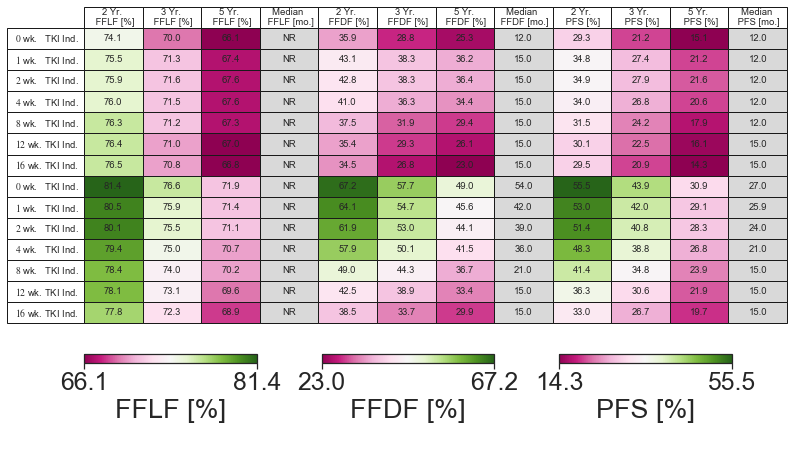

In [14]:
#####################################################################################
##### Summary Table of Outcomes   ###################################################
#####################################################################################

##### Function to Color Coat the Table #####
def cellColor_byColum(cell):   
    cell_colors = np.zeros([np.size(cell,0),np.size(cell,1),4])
    for ind0 in np.arange(0,np.size(cell,0),1):
        for ind1 in [0,1,2,4,5,6,8,9,10]:
            if ind1 < 4:
                colors1 = plt.cm.PiYG(np.linspace(0,1,int(np.max(cell[:,0:3]))-int(np.min(cell[:,0:3]))+1))
                cell_colors[ind0,ind1,:] = colors1[int(cell[ind0,ind1]-np.min(cell[:,0:3]))]
            elif ind1 < 7:
                colors1 = plt.cm.PiYG(np.linspace(0,1,int(np.max(cell[:,4:7]))-int(np.min(cell[:,4:7]))+1))
                cell_colors[ind0,ind1,:] = colors1[int(cell[ind0,ind1]-np.min(cell[:,4:7]))]
            elif ind1 < 11:
                colors1 = plt.cm.PiYG(np.linspace(0,1,int(np.max(cell[:,8:11]))-int(np.min(cell[:,8:11]))+1))
                cell_colors[ind0,ind1,:] = colors1[int(cell[ind0,ind1]-np.min(cell[:,8:11]))]
        for ind1 in [3,7,11]:
            cell_colors[ind0,ind1,:] = np.array([0.85,0.85,0.85,1])
    return cell_colors

##### Format Data and Labels for Table #####
wk_ind = [0,1,2,4,8,12,16]
dataTable_TKICRT = np.zeros([len(wk_ind)*2,12]);
for ipt in range(len(wk_ind)):            
            dataTable_TKICRT[ipt,0:4] = [LR_TKICRT_All[24,ipt,0],LR_TKICRT_All[36,ipt,0],LR_TKICRT_All[60,ipt,0],LR_Med_TKICRT_All[ipt,0]]
            dataTable_TKICRT[ipt,4:8] = [DR_TKICRT_All[24,ipt,0],DR_TKICRT_All[36,ipt,0],DR_TKICRT_All[60,ipt,0],DR_Med_TKICRT_All[ipt,0]]
            dataTable_TKICRT[ipt,8:12] = [PFS_TKICRT_All[24,ipt,0],PFS_TKICRT_All[36,ipt,0],PFS_TKICRT_All[60,ipt,0],PFS_Med_TKICRT_All[ipt,0]]

            dataTable_TKICRT[ipt+len(wk_ind),0:4] = [LR_TKICRT_All[24,ipt,1],LR_TKICRT_All[36,ipt,1],LR_TKICRT_All[60,ipt,1],LR_Med_TKICRT_All[ipt,1]]
            dataTable_TKICRT[ipt+len(wk_ind),4:8] = [DR_TKICRT_All[24,ipt,1],DR_TKICRT_All[36,ipt,1],DR_TKICRT_All[60,ipt,1],DR_Med_TKICRT_All[ipt,1]]
            dataTable_TKICRT[ipt+len(wk_ind),8:12] = [PFS_TKICRT_All[24,ipt,1],PFS_TKICRT_All[36,ipt,1],PFS_TKICRT_All[60,ipt,1],PFS_Med_TKICRT_All[ipt,1]]

#multiply all fractions by 100 (expect medians in column 3,7,11)
dataTable_TKICRT[:,[0,1,2,4,5,6,8,9,10]] = 100*dataTable_TKICRT[:,[0,1,2,4,5,6,8,9,10]]

columns1 = ['2 Yr. \n FFLF [%]', '3 Yr. \n FFLF [%]', '5 Yr. \n FFLF [%]', 'Median \n FFLF [mo.]','2 Yr. \n FFDF [%]', '3 Yr. \n FFDF [%]', '5 Yr. \n FFDF [%]', 'Median \n FFDF [mo.]','2 Yr. \n PFS [%]', '3 Yr. \n PFS [%]', '5 Yr. \n PFS [%]', 'Median \n PFS [mo.]']
rows1 = ['$0$ wk.   TKI Ind.','$1$ wk.   TKI Ind.','$2$ wk.   TKI Ind.','$4$ wk.   TKI Ind.','$8$ wk.   TKI Ind.','$12$ wk. TKI Ind.','$16$ wk. TKI Ind.',
         '$0$ wk.   TKI Ind.','$1$ wk.   TKI Ind.','$2$ wk.   TKI Ind.','$4$ wk.   TKI Ind.','$8$ wk.   TKI Ind.','$12$ wk. TKI Ind.','$16$ wk. TKI Ind.']

VarywkInd_cell = []
for row in range(2*len(wk_ind)):
    VarywkInd_cell.append(['%2.1f'  % (x) for x in dataTable_TKICRT[row]])  
#median LLFL not reached at all time points
for i in range(2*len(wk_ind)):
    VarywkInd_cell[i][3]='NR'             

##### Plot Table #####    
plt.figure(figsize=[14,14])
fig, axs =plt.subplots(2,1)
axs[0].axis('tight')
axs[0].axis('off')
img1 = plt.imshow(dataTable_TKICRT[:,0:3], cmap="PiYG")
img2 = plt.imshow(dataTable_TKICRT[:,4:7], cmap="PiYG")
img3 = plt.imshow(dataTable_TKICRT[:,8:11], cmap="PiYG")
img1.set_visible(False)
img2.set_visible(False)
img3.set_visible(False)
cbaxes1 = fig.add_axes([0.125, 0.4, 0.4, 0.03]) 
cbar1=plt.colorbar(orientation='horizontal',cax=cbaxes1,ticks=[np.min(dataTable_TKICRT[:,8:11]),np.max(dataTable_TKICRT[:,8:11])])
cbar1.set_ticklabels([np.round(np.min(dataTable_TKICRT[:,0:3]),1),np.round(np.max(dataTable_TKICRT[:,0:3]),1)])
cbar1.set_label('FFLF [%]')
cbaxes2 = fig.add_axes([0.675, 0.4, 0.4, 0.03]) 
cbar2=plt.colorbar(orientation='horizontal',cax=cbaxes2,ticks=[np.min(dataTable_TKICRT[:,8:11]),np.max(dataTable_TKICRT[:,8:11])])
cbar2.set_label('FFDF [%]')
cbar2.set_ticklabels([np.round(np.min(dataTable_TKICRT[:,4:7]),1),np.round(np.max(dataTable_TKICRT[:,4:7]),1)])
cbaxes3 = fig.add_axes([1.225, 0.4, 0.4, 0.03]) 
cbar3=plt.colorbar(orientation='horizontal',cax=cbaxes3,ticks=[np.min(dataTable_TKICRT[:,8:11]),np.max(dataTable_TKICRT[:,8:11])])
cbar3.set_label('PFS [%]')
cbar3.set_ticklabels([np.round(np.min(dataTable_TKICRT[:,8:11]),1),np.round(np.max(dataTable_TKICRT[:,8:11]),1)])
the_table = axs[0].table(cellText=VarywkInd_cell,cellColours=cellColor_byColum(dataTable_TKICRT),
              cellLoc='center',
              rowLabels=np.array(rows1),colLabels=columns1,
              loc='top',bbox=[0, 0, 2.1, 3.2])
the_table.auto_set_font_size(False)
the_table.set_fontsize(9.5)
axs[1].axis('off')

<Figure size 432x288 with 0 Axes>

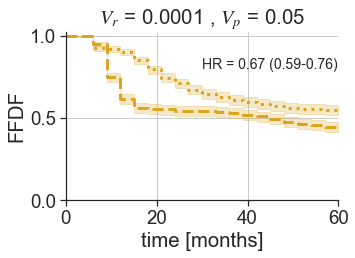

<Figure size 432x288 with 0 Axes>

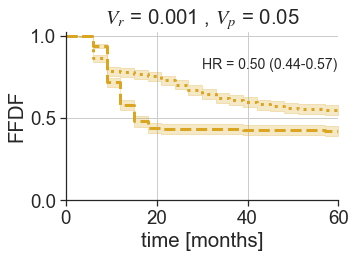

<Figure size 432x288 with 0 Axes>

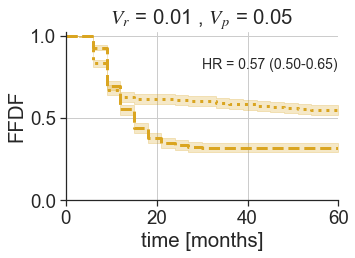

<Figure size 432x288 with 0 Axes>

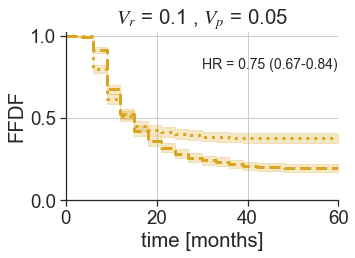

<Figure size 432x288 with 0 Axes>

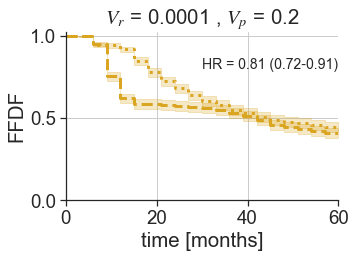

<Figure size 432x288 with 0 Axes>

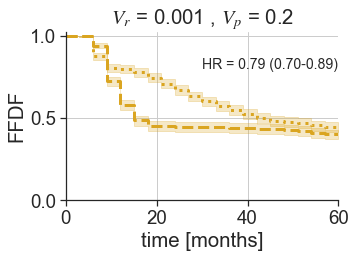

<Figure size 432x288 with 0 Axes>

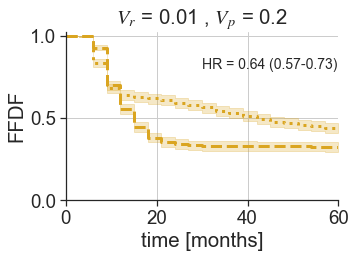

<Figure size 432x288 with 0 Axes>

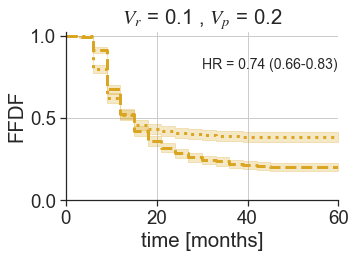

<Figure size 432x288 with 0 Axes>

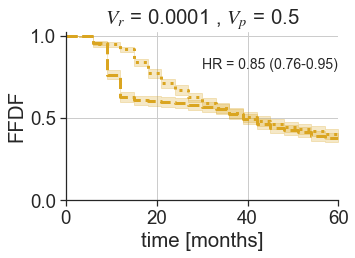

<Figure size 432x288 with 0 Axes>

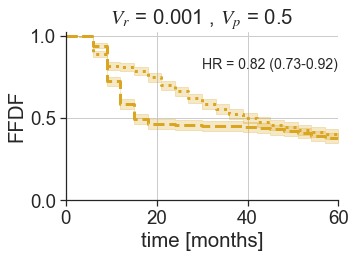

<Figure size 432x288 with 0 Axes>

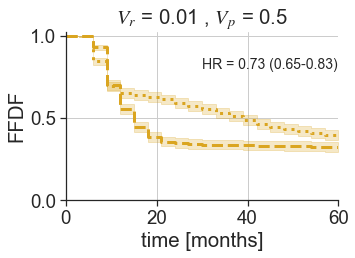

<Figure size 432x288 with 0 Axes>

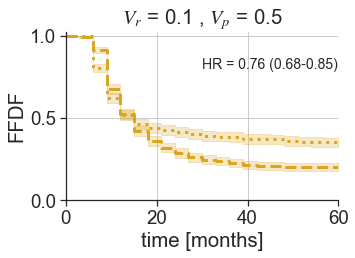

In [15]:
#####################################################################################
## FFDF K-P stratified by initial resistance/persistance for 2 vs 12 week TKI+CRT ###
#####################################################################################
        
# 6 for DR, 2 v 12 week  
pval_ResPer = np.zeros([len(initPerFrac),len(initResFrac)])
HR_ResPer = np.zeros([3,len(initPerFrac),len(initResFrac)])
for ipp in range(len(initPerFrac)):
    for ip in range(len(initResFrac)):
        PatRes_VpVr_TKICRT_2wkMain =  np.ndarray.flatten(PatRes_TKICRT[:,1,ip,ipp,2,1])   
        PatRes_VpVr_TKICRT_12wkMain =  np.ndarray.flatten(PatRes_TKICRT[:,1,ip,ipp,5,1])  
        HR,HR_95CI_L,HR_95CI_H,V = calcHazardRatio(PatRes_VpVr_TKICRT_2wkMain,PatRes_VpVr_TKICRT_12wkMain) 
        results = logrank_test(PatRes_VpVr_TKICRT_2wkMain, PatRes_VpVr_TKICRT_12wkMain, PatRes_VpVr_TKICRT_2wkMain<60, PatRes_VpVr_TKICRT_12wkMain<60,t_0=-1)
        ipval = results.p_value        
        HR_ResPer[:,ipp,ip] = [HR,HR_95CI_L,HR_95CI_H]
        pval_ResPer[ipp,ip] = ipval
        plt.figure()
        with seaborn.axes_style("ticks"):
            seaborn.set(style='ticks',font_scale=1.7)
            fig,ax = plt.subplots(figsize=[5.5,4])        
            kmf.fit(PatRes_VpVr_TKICRT_2wkMain,event_observed= PatRes_VpVr_TKICRT_2wkMain<60,alpha=1-0.95)
            ax = kmf.plot(ax=ax,color = 'goldenrod',linewidth=3,linestyle = ':',legend=False)
            kmf.fit(PatRes_VpVr_TKICRT_12wkMain,event_observed= PatRes_VpVr_TKICRT_12wkMain<60,alpha=1-0.95)
            ax = kmf.plot(ax=ax,color = 'goldenrod',linewidth=3,linestyle = '--',legend=False)
            plt.text(30,0.8,'HR = {0:.2f} ({1:.2f}-{2:.2f})'.format(HR_ResPer[0,ipp,ip],HR_ResPer[1,ipp,ip],HR_ResPer[2,ipp,ip]),fontsize=14)
            plt.xlim([0,60])
            plt.ylim([0,1.025])
            plt.title('$V_r$ = {0} , $V_p$ = {1}'.format(initResFrac[ip],initPerFrac[ipp]))
            plt.xlabel('time [months]')
            plt.ylabel('FFDF')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout()  
            plt.grid()

<Figure size 864x432 with 0 Axes>

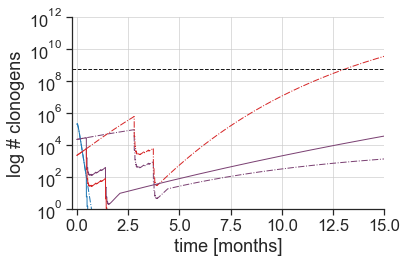

<Figure size 864x432 with 0 Axes>

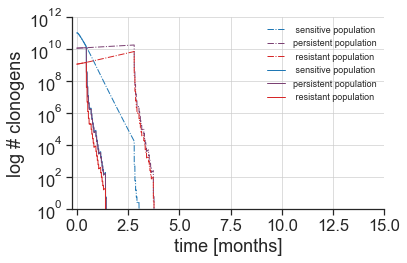

In [16]:
####-------------------------------------------------------------------------------------------------------####
#
# TKI pre and post CRT
#
####-------------------------------------------------------------------------------------------------------####

def Dynamic_TKIpreANDpostCRTuntilProg_MetsDRRLRR_CoMorbid_local(N0_total,N0_persister_frac,N0_resistance,r_sen,r_per,r_res,beta,wkTKIset,p_mutation,Gmet_scl,DRRlvl,RadAlpha,Cisplatin_u,Vinblastine_u):
    
    capacity = 30; #[cm] diameter tumor from Geng et al.
    V_Death = 13; #[cm] diameter tumor from Geng et al.
    Vlimit=5.8e8*4/3*np.pi*(capacity/2)**3; # carrying capacity from Geng et al.
    EndT=5.8e8*4/3*np.pi*(V_Death/2)**3; # "death condition" from Geng et al. (not used in this study)
    
    h0=np.array([N0_total*(1-N0_persister_frac)-N0_resistance,N0_resistance,N0_total*N0_persister_frac])

    h0_local = h0
    h0_dist = (Gmet_scl)*h0
    h0 = (1+Gmet_scl)*h0
        
    # Arrays to store results
    # total,local,distant
    cellSensTreated = np.zeros([18010,3]); #(30*12*5+1)*10
    cellPerTreated = np.zeros([18010,3]);
    cellResTreated = np.zeros([18010,3]);
    cellTotalTreated = np.zeros([18010,3]);    
    erlotinibPlasma = np.zeros(18010); 

    cellSensTreated[0,0] = h0[0];
    cellPerTreated[0,0] =  h0[2];
    cellResTreated[0,0] =  h0[1];
    cellTotalTreated[0,0] = np.sum(h0); 
    
    cellSensTreated[0,1] = h0_local[0];
    cellPerTreated[0,1] =  h0_local[2];
    cellResTreated[0,1] =  h0_local[1];
    cellTotalTreated[0,1] = np.sum(h0_local); 
    
    cellSensTreated[0,2] = h0_dist[0];
    cellPerTreated[0,2] =  h0_dist[2];
    cellResTreated[0,2] =  h0_dist[1];
    cellTotalTreated[0,2] = np.sum(h0_dist); 
    
    ####### TKI wkTKIset weeks #######
    
    # Vector of initial conditions
    y0 = 0
    doseErlotinibDaily = 150.0;
    # get plasma level for every timepoint

    #t definition of TIME
    # set up TKI daily dosing for pharmacokinetics 
    tInterval = 0.1
    tTKI = np.arange(tInterval, wkTKIset*7+tInterval/10, tInterval)
    daysTKI = wkTKIset*7  # Number of days to simulate
    erlotinibStart = 0
    doseErlotinibDaily = 150.0;
    doseIntervalDaily = np.zeros(np.size(tTKI))+1;
    plasmadoseIntervalDaily = np.zeros(np.size(tTKI)+1);
    for tCounter in np.arange(erlotinibStart*10, (daysTKI)*10, 10):  
            doseIntervalDaily[int(tCounter)]=doseErlotinibDaily
            plasmadoseIntervalDaily[int(tCounter)]= 1.0182 + 0.0114*doseErlotinibDaily;    
    erlotinibPlasma[0]=y0    
    
    # TKI Treatment Loop 
    step=0;Cured=False;t_cure = 18000;
    for step in range(1,np.size(tTKI)+1):
        intTime = [0, 1]
        # Get dose for this step
        
        # Solve the pharmacokinetic ODEs
        erlotinib =  sc.integrate.odeint(Pharmacokinetics, y0, intTime, args=(plasmadoseIntervalDaily[step], ))
        # Append result
        erlotinibPlasma[step]=erlotinib[0]
        # Update initial condition for next step
        y0 = [ float(erlotinib[1]), ]

        # Get dose for this step
        drugLevel = erlotinibPlasma[step]   
        
        # Solve the TKI ODEs
        cellsTreat_local = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_local, intTime, args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,drugLevel))
        cellsTreat_dist = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_dist, intTime, args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,drugLevel))

        # Extract number at the end of day
        # Append result
        cellSensTreated[step,:]=np.array([float(cellsTreat_local[1,0])+float(cellsTreat_dist[1,0]), float(cellsTreat_local[1,0]), float(cellsTreat_dist[1,0])])
        cellResTreated[step,:]= np.array([float(cellsTreat_local[1,1])+float(cellsTreat_dist[1,1]), float(cellsTreat_local[1,1]), float(cellsTreat_dist[1,1])])
        cellPerTreated[step,:]= np.array([float(cellsTreat_local[1,2])+float(cellsTreat_dist[1,2]), float(cellsTreat_local[1,2]), float(cellsTreat_dist[1,2])])

        #if a comparantent has <1 cell set compartment to 0
        cellSensTreated[step,cellSensTreated[step,:]<1]=0
        cellResTreated[step,cellResTreated[step,:]<1]=0
        cellPerTreated[step,cellPerTreated[step,:]<1]=0
        
        # Update initial condition for next step
        h0_local =  np.array([cellSensTreated[step,1], cellResTreated[step,1], cellPerTreated[step,1]])
        h0_dist =   np.array([cellSensTreated[step,2], cellResTreated[step,2], cellPerTreated[step,2]])
        h0 = h0_local+h0_dist
        
        cellTotalTreated[step,:]=cellSensTreated[step,:]+cellResTreated[step,:]+cellPerTreated[step,:]
        if cellTotalTreated[step,0]<1:
            Cured =True
            t_cure = step
            break
        
    ####### CRT 7 weeks #######
    Vinblastine_C0=5
    Cisplatin_C0=100
    current_alpha=RadAlpha
    t_half=1
    
    next_step = np.size(tTKI)+1
    tCRT = np.arange(wkTKIset*7+tInterval,wkTKIset*7+7*7+tInterval/10, tInterval)
    days = np.round(np.arange(1.,50,tInterval),1)

    #only local in field cells affected by CRT
    #day will count from start of treatment
    if Cured==False:
        for step in range(next_step,next_step+np.size(tCRT)): 
            #5 weeks vinblastin +cisplatin
            if days[step-next_step]<36 and np.mod(days[step-next_step]+6,7)==0:
                Vinblastine_C=Vinblastine_C0;
                h0_local=h0_local*chemo(Vinblastine_u,Vinblastine_C);
                h0_dist=h0_dist*chemo(Vinblastine_u,Vinblastine_C);
            elif days[step-next_step]<36 and np.mod(days[step-next_step],1)==0:
                Vinblastine_C=Vinblastine_C0*(1./2)**((np.mod(days[step-next_step]-1,7))/t_half)  #decay
                h0_local=h0_local*chemo(Vinblastine_u,Vinblastine_C);
                h0_dist=h0_dist*chemo(Vinblastine_u,Vinblastine_C);
            if days[step-next_step]==1 or days[step-next_step]==29:
                Cisplatin_C=Cisplatin_C0;
                h0_local=h0_local*chemo(Cisplatin_u,Cisplatin_C);
                h0_dist=h0_dist*chemo(Cisplatin_u,Cisplatin_C);
            elif days[step-next_step]<50 and np.mod(days[step-next_step],1)==0:
                Cisplatin_C=Cisplatin_C0*(1./2)**((np.mod(days[step-next_step]-1,28))/t_half)  #decay
                h0_local=h0_local*chemo(Cisplatin_u,Cisplatin_C);
                h0_dist=h0_dist*chemo(Cisplatin_u,Cisplatin_C);
            
            # 60 Gy  2*30 - local only
            if (days[step-next_step]<42):
                if ((np.mod(days[step-next_step]+6,7)==0 or np.mod(days[step-next_step]+5,7)==0 or np.mod(days[step-next_step]+4,7)==0 or np.mod(days[step-next_step]+3,7)==0 or np.mod(days[step-next_step]+2,7)==0)):  
                    h0_local=h0_local*radiation(current_alpha,current_alpha/10,2)
            
            #Make New Gompertz Growth+Mutation 
            intTime = [0, 1]
            cellsGrow_local = sc.integrate.odeint(GompertzMutation, h0_local, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
            cellsGrow_dist  = sc.integrate.odeint(GompertzMutation, h0_dist, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        

            # Extract number at the end of day
            # Append result
            cellSensTreated[step,:]=np.array([float(cellsGrow_local[1,0])+float(cellsGrow_dist[1,0]), float(cellsGrow_local[1,0]), float(cellsGrow_dist[1,0])])
            cellResTreated[step,:]= np.array([float(cellsGrow_local[1,1])+float(cellsGrow_dist[1,1]), float(cellsGrow_local[1,1]), float(cellsGrow_dist[1,1])])
            cellPerTreated[step,:]= np.array([float(cellsGrow_local[1,2])+float(cellsGrow_dist[1,2]), float(cellsGrow_local[1,2]), float(cellsGrow_dist[1,2])])

            #if a comparantent has <1 cell set compartment to 0
            cellSensTreated[step,cellSensTreated[step,:]<1]=0
            cellResTreated[step,cellResTreated[step,:]<1]=0
            cellPerTreated[step,cellPerTreated[step,:]<1]=0
            
            # Update initial condition for next step
            h0_local =  np.array([cellSensTreated[step,1], cellResTreated[step,1], cellPerTreated[step,1]])
            h0_dist =   np.array([cellSensTreated[step,2], cellResTreated[step,2], cellPerTreated[step,2]])
            h0 = h0_local+h0_dist
            
            cellTotalTreated[step,:]=cellSensTreated[step,:]+cellResTreated[step,:]+cellPerTreated[step,:]
            if cellTotalTreated[step,0]<1:
                Cured =True
                t_cure = step
                break
    
    ####### TKI Until Progression #######
    
    #t definition of TIME
    tInterval = 0.1
    next_step = step
    steps_remaining = 18010-(next_step)
    tTKI = np.arange((7+wkTKIset)*7+tInterval,(7+wkTKIset)*7+steps_remaining/10+tInterval/10, tInterval)
    daysTKI = np.size(tTKI)/10  # Number of days to simulate 
    
    h0_local = np.append(h0_local,0)
    h0_dist = np.append(h0_dist,0)
    h0 = np.append(h0,0)

    if Cured==False:
        for step in range(next_step,next_step+np.size(tTKI),10):
            intTime = np.arange(0,1,tInterval)
                
            doseErlotinibDaily = 150
            if step>next_step:
                erlotinibStart =  sc.integrate.odeint(Pharmacokinetics, h0[3], [0,1], args=([1.0182 + 0.0114*doseErlotinibDaily], ))
                erlotinibPlasma[step] = erlotinibStart[1]
                cellsTreat_local = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_local[0:3], [0, 1], args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,erlotinibStart[1]))
                cellsTreat_dist = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_dist[0:3], [0, 1], args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,erlotinibStart[1]))
    
                cellSensTreated[step,:]=np.array([float(cellsTreat_local[1,0])+float(cellsTreat_dist[1,0]), float(cellsTreat_local[1,0]), float(cellsTreat_dist[1,0])])
                cellResTreated[step,:]= np.array([float(cellsTreat_local[1,1])+float(cellsTreat_dist[1,1]), float(cellsTreat_local[1,1]), float(cellsTreat_dist[1,1])])
                cellPerTreated[step,:]= np.array([float(cellsTreat_local[1,2])+float(cellsTreat_dist[1,2]), float(cellsTreat_local[1,2]), float(cellsTreat_dist[1,2])])
    
            # Update initial condition for next step
            h0_local =  np.array([cellSensTreated[step,1], cellResTreated[step,1], cellPerTreated[step,1],erlotinibPlasma[step]])
            h0_dist =   np.array([cellSensTreated[step,2], cellResTreated[step,2], cellPerTreated[step,2],erlotinibPlasma[step]])
            h0 = h0_local+h0_dist; h0[3] = h0[3]/2; # because doubled when local and distant addded
            
            # Solve the ODEs
            doseinterval=0
            cellsTreat_local = sc.integrate.odeint(EGFRkineticsGompertz_opt2_Pharmacokinetics, h0_local, intTime, args=(Vlimit, r_sen, r_res, r_per, p_mutation, beta,doseinterval))
            cellsTreat_dist = sc.integrate.odeint(EGFRkineticsGompertz_opt2_Pharmacokinetics, h0_dist, intTime, args=(Vlimit, r_sen, r_res, r_per, p_mutation, beta,doseinterval))
            cellsTreat_local[np.isnan(cellsTreat_local)]=0
            cellsTreat_dist[np.isnan(cellsTreat_dist)]=0
            
            # Extract number at the end of day
            # Append result
            cellSensTreated[step+1:step+10,:]=np.transpose(np.array([(cellsTreat_local[1:10,0])+(cellsTreat_dist[1:10,0]), (cellsTreat_local[1:10,0]), (cellsTreat_dist[1:10,0])]))
            cellResTreated[step+1:step+10,:]= np.transpose(np.array([(cellsTreat_local[1:10,1])+(cellsTreat_dist[1:10,1]), (cellsTreat_local[1:10,1]), (cellsTreat_dist[1:10,1])]))
            cellPerTreated[step+1:step+10,:]= np.transpose(np.array([(cellsTreat_local[1:10,2])+(cellsTreat_dist[1:10,2]), (cellsTreat_local[1:10,2]), (cellsTreat_dist[1:10,2])]))
            erlotinibPlasma[step+1:step+10]=cellsTreat_local[1:10,3]
    
            #if a comparantent has <1 cell set compartment to 0
            cellSensTreated[step:step+10,cellSensTreated[step+9,:]<1]=0
            cellResTreated[step:step+10,cellResTreated[step+9,:]<1]=0
            cellPerTreated[step:step+10,cellPerTreated[step+9,:]<1]=0
            
            # Update initial condition for next step
            h0_local =  np.array([cellSensTreated[step+9,1], cellResTreated[step+9,1], cellPerTreated[step+9,1],erlotinibPlasma[step+9]])
            h0_dist =   np.array([cellSensTreated[step+9,2], cellResTreated[step+9,2], cellPerTreated[step+9,2],erlotinibPlasma[step+9]])
            h0 = h0_local+h0_dist; h0[3] = h0[3]/2; # because doubled when local and distant addded           
            
            cellTotalTreated=cellSensTreated+cellResTreated+cellPerTreated
            if cellTotalTreated[step+9,0]<1:
                Cured =True
                t_cure = step
                break
            
            if ((cellTotalTreated[step+9,1]>N0_total)|(cellTotalTreated[step+9,2]>DRRlvl)) & (step>10) & (np.mod(step,900)==0):
                break
            
    ####### regrowth after treatment if not cured or progression #######    
    steps_remaining = 18010-(step)
    if (Cured==False)&(steps_remaining>0): 
        intTime = np.arange(0,steps_remaining,1)
        cellsGrow_local = sc.integrate.odeint(GompertzMutation, h0_local[0:3], intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
        cellsGrow_dist  = sc.integrate.odeint(GompertzMutation, h0_dist[0:3], intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
        cellSensTreated[step+1:18010,:]=np.transpose(np.array([(cellsGrow_local[1:,0])+(cellsGrow_dist[1:,0]), (cellsGrow_local[1:,0]), (cellsGrow_dist[1:,0])]))
        cellResTreated[step+1:18010,:]= np.transpose(np.array([(cellsGrow_local[1:,1])+(cellsGrow_dist[1:,1]), (cellsGrow_local[1:,1]), (cellsGrow_dist[1:,1])]))
        cellPerTreated[step+1:18010,:]= np.transpose(np.array([(cellsGrow_local[1:,2])+(cellsGrow_dist[1:,2]), (cellsGrow_local[1:,2]), (cellsGrow_dist[1:,2])]))
        cellTotalTreated[step+1:18010,:] = cellSensTreated[step+1:18010,:]+cellResTreated[step+1:18010,:]+cellPerTreated[step+1:18010,:]

    return cellSensTreated,cellResTreated,cellPerTreated,cellTotalTreated

#####################################################################################
## plot cell trajectories
#####################################################################################                
 
### get representative model parameters ###
N0_total = 5.8e8*4/3*np.pi*(np.median(Stest_InitialDiameters)/2)**3
N0_persister_frac = 0.1
N0_resistance = 0.01*N0_total

beta = np.percentile(Gbeta,30)
Vinblastine_u = np.median(GVinblastine_u)
Cisplatin_u = np.median(Gcisplatin_u)
RadAlpha = np.median(Galpha)

r_sen = np.median(Gr_sen)
r_per = r_sen/4
r_res = r_sen;

Gmet_scl = 2e-6
DRRlvl = 5.8e8
p_mutation = 1e-7

### get cell trajectories with 2 and 12 weeks of induction ###
wkTKIset=2
cellSensWithMain2wk,cellResWithMain2wk,cellPerWithMain2wk,cellTotWithMain2wk = Dynamic_TKIpreANDpostCRTuntilProg_MetsDRRLRR_CoMorbid_local(N0_total,N0_persister_frac,N0_resistance,r_sen,r_per,r_res,beta,wkTKIset,p_mutation,Gmet_scl,DRRlvl,RadAlpha,Cisplatin_u,Vinblastine_u)

wkTKIset=12
cellSensWithMain12wk,cellResWithMain12wk,cellPerWithMain12wk,cellTotWithMain12wk = Dynamic_TKIpreANDpostCRTuntilProg_MetsDRRLRR_CoMorbid_local(N0_total,N0_persister_frac,N0_resistance,r_sen,r_per,r_res,beta,wkTKIset,p_mutation,Gmet_scl,DRRlvl,RadAlpha,Cisplatin_u,Vinblastine_u)

#colors to be used through out paper
cscheme = plt.cm.tab10
cscheme2 = plt.cm.tab20b
C = np.zeros([4,4]);
C[0,:] = [0,0,0,1]
C[1,:] = np.array(cscheme(0))
C[2,:] = np.array(cscheme2(16))
C[3,:] = np.array(cscheme(3))

t = np.arange(0,1801,0.1)
#Distant fraction cell trajectory plot
plt.figure(figsize=[12,6])    
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.5)
    fig,ax = plt.subplots()
    plt.semilogy(t/30,cellSensWithMain12wk[:,2],'-.',color = C[1,:],linewidth = 1,label='sensitive population' )
    plt.semilogy(t/30,cellPerWithMain12wk[:,2],'-.',color = C[2,:],linewidth = 1, label='persistent population')
    plt.semilogy(t/30,cellResWithMain12wk[:,2],'-.',color = C[3,:],linewidth = 1, label='resistant population')
    plt.semilogy(t/30,cellSensWithMain2wk[:,2],color = C[1,:],linewidth = 1,label='sensitive population' )
    plt.semilogy(t/30,cellPerWithMain2wk[:,2],color = C[2,:],linewidth = 1, label='persistent population')
    plt.semilogy(t/30,cellResWithMain2wk[:,2],color = C[3,:],linewidth = 1, label='resistant population')   
    plt.semilogy([-0.25,61],[5.8e8,5.8e8],'k--',linewidth = 1,label='1cc')
    plt.ylim([10**(0),10**(12)])
    plt.xlim([-0.25,15])
    plt.xticks([0,2.5,5,7.5,10,12.5,15])
    plt.yticks([10**(0),10**(2),10**(4),10**(6),10**(8),10**(10),10**(12)])
    plt.xlabel('time [months]')
    plt.ylabel('log # clonogens')
    plt.grid(axis='y', which='major', linestyle='-', linewidth=0.66)
    plt.grid(axis='x', which='major', linestyle='-', linewidth=0.66)
    plt.grid(axis='y', which='minor', linestyle=':', linewidth=0.33)  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()

#Listant fraction cell trajectory plot
plt.figure(figsize=[12,6])    
with seaborn.axes_style("ticks"):
    seaborn.set(style='ticks',font_scale=1.5)
    fig,ax = plt.subplots()
    plt.semilogy(t/30,cellSensWithMain12wk[:,1],'-.',color = C[1,:],linewidth = 1,label=' sensitive population' )
    plt.semilogy(t/30,cellPerWithMain12wk[:,1],'-.',color = C[2,:],linewidth = 1, label='persistent population')
    plt.semilogy(t/30,cellResWithMain12wk[:,1],'-.',color = C[3,:],linewidth = 1, label=' resistant population')
    plt.semilogy(t/30,cellSensWithMain2wk[:,1],color = C[1,:],linewidth = 1,label=' sensitive population' )
    plt.semilogy(t/30,cellPerWithMain2wk[:,1],color = C[2,:],linewidth = 1, label='persistent population')
    plt.semilogy(t/30,cellResWithMain2wk[:,1],color = C[3,:],linewidth = 1, label=' resistant population')   
    plt.ylim([10**(0),10**(12)])
    plt.xlim([-0.25,15])
    plt.xticks([0,2.5,5,7.5,10,12.5,15])
    plt.yticks([10**(0),10**(2),10**(4),10**(6),10**(8),10**(10),10**(12)])
    plt.xlabel('time [months]')
    plt.ylabel('log # clonogens')
    plt.grid(axis='y', which='major', linestyle='-', linewidth=0.66)
    plt.grid(axis='x', which='major', linestyle='-', linewidth=0.66)
    plt.grid(axis='y', which='minor', linestyle=':', linewidth=0.33)  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc=0,prop={'size': 9}, frameon=False)
    plt.tight_layout() 